In [1]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
from keras import backend as K

image_height = 128
image_width = 128

def train_id_to_path(x):
    return 'SAXSdata1/' + str(x) + ".tif"
    #def test_id_to_path(x):
    #return 'SAXSdata/' + x + ".tif"

def path_to_eagertensor(image_path):
    image = cv2.imread(image_path)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (128, 128)), aspect='auto',cmap ='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (128, 128)), aspect='auto',cmap ='gray')
    plt.tight_layout()
    
def getdata():
    cols = ["id", "tem", "strain", "area"]
    df = pd.read_csv("SAXSdata1/saxsdata1.dat", sep=" ", header=None, names=cols)
    df["img_path"] = df["id"].apply(train_id_to_path)
    X = []
    Y = df[["tem","strain"]]
   
    for img in df['img_path']:
        new_img_tensor = path_to_eagertensor(img)
        X.append(new_img_tensor)
    
    X = np.array(X)
    print(type(X),X.shape)
    print(type(X),Y.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
    print(type(x_train),x_train.shape)
    print(type(x_test),x_test.shape)
    print(type(y_train),y_train.shape)
    print(type(y_test),y_test.shape)
    return x_train, x_test, y_train, y_test

In [2]:
class VAE():
    def __init__(self):

        self.input_dim = 128*128
        self.latent_dim = 2
        
        self.inputs = kr.Input(shape=(self.input_dim,))
        
        x = kr.layers.Dense(256, activation='relu')(self.inputs)
        x = kr.layers.Dense(128, activation='relu')(x)
        x = kr.layers.Dense(64, activation='relu')(x)

        # shape info needed to build decoder model
        self.shape = x.get_shape().as_list()

        #x = kr.layers.Dense(16, activation='relu')(x)
        self.z_mean = kr.layers.Dense(self.latent_dim)(x)
        self.z_log_var = kr.layers.Dense(self.latent_dim)(x)
        self.z = kr.layers.Lambda(self.sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_var])
        
        # build decoder model
        #latent_inputs = kr.Input(shape=(latent_dim,), name='z_sampling')
        self.dec1 = kr.layers.Dense(64, activation='relu')
        self.dec2 = kr.layers.Dense(128, activation='relu')
        self.dec3 = kr.layers.Dense(256, activation='relu')
        self.dec_out = kr.layers.Dense(self.input_dim, activation='sigmoid')
        
        x = self.dec1(self.z)
        x = self.dec2(x)
        x = self.dec3(x)
        self.outputs = self.dec_out(x)   
        
    # sampling function
    def sampling(self, args):
        z_mean, z_log_var = args
        nd = K.shape(z_mean)[0]
        nc = self.latent_dim
        eps = K.random_normal(shape=(nd, nc), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * eps

    def vae(self):
        return kr.Model(self.inputs, self.outputs)
    
    def encoder(self):
        return kr.Model(self.inputs, self.z_mean)
    
    def decoder(self):
        z = kr.Input(shape=(self.latent_dim,))
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x_out = self.dec_out(x)  
        return kr.Model(z, x_out)

    def loss(self):
        mse = kr.metrics.mean_absolute_error(self.inputs, self.outputs)
        xent_loss = self.input_dim * mse
        kl = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = - 0.5 * K.sum(kl, axis=-1)
        vae_loss = K.mean(xent_loss + kl_loss)
        return vae_loss

In [3]:
x_train, x_test, y_train, y_test = getdata()
n, h, w, e = x_train.shape
n1, h1, w1, e1 = x_test.shape
X_train = x_train.reshape(n, -1)
X_test = x_test.reshape(n1, -1)
min_max_scaler = MinMaxScaler()
#X_train = min_max_scaler.fit_transform(X_train)
#X_test = min_max_scaler.fit_transform(X_test)

<class 'numpy.ndarray'> (5046, 128, 128, 1)
<class 'numpy.ndarray'> (5046, 2)
<class 'numpy.ndarray'> (4793, 128, 128, 1)
<class 'numpy.ndarray'> (253, 128, 128, 1)
<class 'pandas.core.frame.DataFrame'> (4793, 2)
<class 'pandas.core.frame.DataFrame'> (253, 2)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          4194560     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_______________________________________________________________________________________

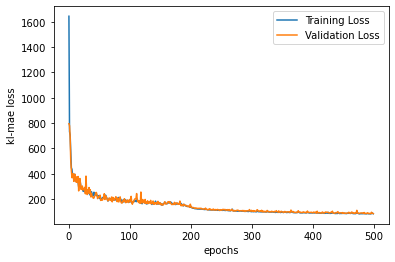

In [4]:
seed = 0
batch_size = 128
epochs = 500

np.random.seed(seed)
vae = VAE()
model = vae.vae()
model.summary()
model.add_loss(vae.loss())

np.random.seed(seed)
model.compile(optimizer='adam', loss=None)
history = model.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
plt.legend()

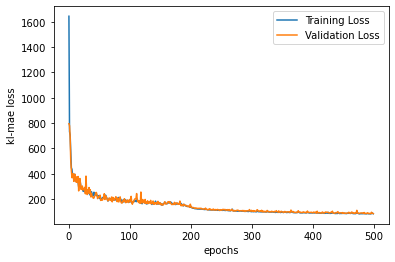

In [5]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
plt.legend()

<class 'numpy.ndarray'> (121, 2)


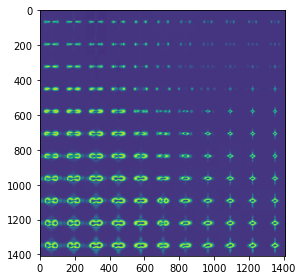

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ])

In [6]:
# decode images from 2-dim latent z
ndiv = 11 # number of images for axis
dec = vae.decoder()
gx = np.linspace(-1, 1.5, ndiv)
gy = np.linspace(1, -1.5, ndiv)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gxx.reshape(-1,1), gyy.reshape(-1,1), axis=1)
print(type(z),z.shape)
x = dec.predict(z)
dst = x.reshape(ndiv,ndiv,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(ndiv*128, ndiv*128)

# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()
gx

In [7]:
from matplotlib import cm
from skimage import io as skio
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('vae_out_%03d.png' % 11, out)

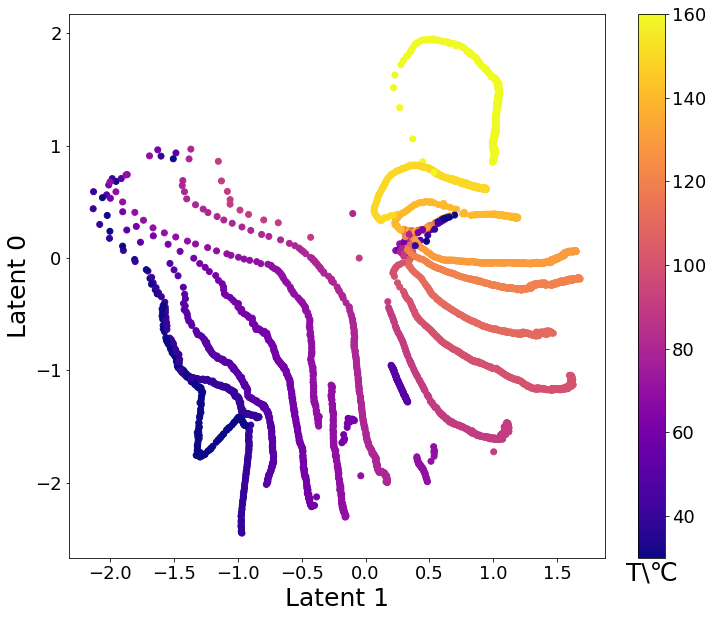

In [7]:
enc = vae.encoder()
def plot_digits1(X, y, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(X)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap = 'plasma')
    #my_x_ticks = np.arange(-2,3,0.3)
    #my_y_ticks = np.arange(-2,3,0.3)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_xlabel('T\℃', size=25)
    plt.xlabel("Latent 1",fontsize = 25)
    plt.ylabel("Latent 0",fontsize = 25)
    #plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\1")
    plt.show()
def plot_digits2(X, y, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(X)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap = 'plasma')
    #my_x_ticks = np.arange(-2,3,0.3)
    #my_y_ticks = np.arange(-2,3,0.3)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_xlabel('ε [%]', size=25)
    plt.xlabel("Latent 1",fontsize = 25)
    plt.ylabel("Latent 0",fontsize = 25)
    #plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\1")
    plt.show()
plot_digits1(X_train, y_train["tem"], enc)  # y for label coloring 

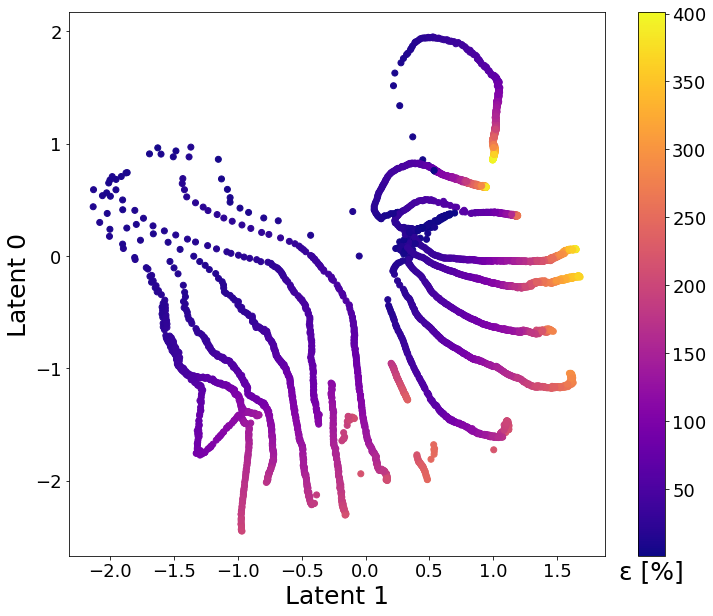

In [8]:
plot_digits2(X_train, y_train["strain"], enc)  # y for label coloring 

In [ ]:
n = 100
gx = np.linspace(-3, 2, n)
gy = np.linspace(-2, 3, n)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gxx.reshape(-1,1), gyy.reshape(-1,1), axis=1)
z0 = [[-1, 2]]
z0 = np.array(z0)
x0 = dec.predict(z0)
x = dec.predict(z)
mae1 = np.zeros(shape=(n*n,))
for i in range(x.shape[0]):
    mae1[i] = kr.metrics.mean_absolute_error(x[i],x0)
mae1 = mae1.reshape(n,n)
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(mae1, cmap = 'Reds', origin = 'lower')
plt.xticks(np.arange(0,110,20),np.arange(-3,2.1,1))
plt.yticks(np.arange(0,110,20),np.arange(-2,3.1,1))

z0 = [[1, 2]]
z0 = np.array(z0)
x0 = dec.predict(z0)
x = dec.predict(z)
mae2 = np.zeros(shape=(n*n,))
for i in range(x.shape[0]):
    mae2[i] = kr.metrics.mean_absolute_error(x[i],x0)
mae2 = mae2.reshape(n,n)
plt.subplot(222)
plt.imshow(mae2, cmap = 'Reds', origin = 'lower')
plt.xticks(np.arange(0,110,20),np.arange(-3,2.1,1))
plt.yticks(np.arange(0,110,20),np.arange(-2,3.1,1))

z0 = [[-0.5, -0]]
z0 = np.array(z0)
x0 = dec.predict(z0)
x = dec.predict(z)
mae3 = np.zeros(shape=(n*n,))
for i in range(x.shape[0]):
    mae3[i] = kr.metrics.mean_absolute_error(x[i],x0)
mae3 = mae3.reshape(n,n)
plt.subplot(223)
plt.imshow(mae3, cmap = 'Reds', origin = 'lower')
plt.xticks(np.arange(0,110,20),np.arange(-3,2.1,1))
plt.yticks(np.arange(0,110,20),np.arange(-2,3.1,1))

z0 = [[1, -1]]
z0 = np.array(z0)
x0 = dec.predict(z0)
x = dec.predict(z)
mae4 = np.zeros(shape=(n*n,))
for i in range(x.shape[0]):
    mae4[i] = kr.metrics.mean_absolute_error(x[i],x0)
mae4 = mae4.reshape(n,n)
plt.subplot(224)
plt.imshow(mae4, cmap = 'Reds', origin = 'lower')
plt.xticks(np.arange(0,110,20),np.arange(-3,2.1,1))
plt.yticks(np.arange(0,110,20),np.arange(-2,3.1,1))
plt.subplots_adjust(bottom=0.3, right=0.55, top=0.7)
cax = plt.axes([0.57, 0.3, 0.02, 0.4])
cb = plt.colorbar(cax=cax)
cb.ax.set_xlabel('mae', size=11)
#plt.savefig(r"C:\Users\zch\Desktop\6.1\数据整理\1")

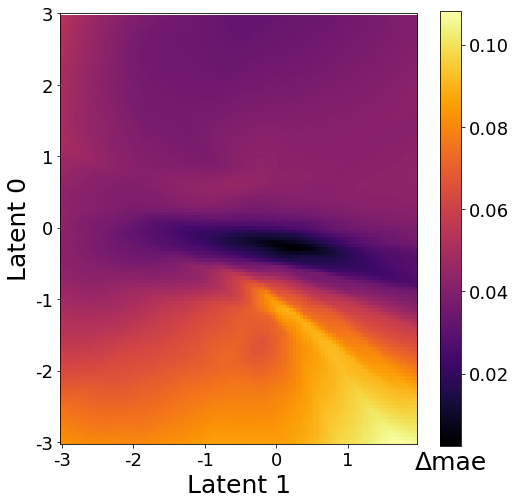

In [48]:
n1 = 100
n2 = 120
gx = np.linspace(-3, 2, n1)
gy = np.linspace(-3, 3, n2)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gxx.reshape(-1,1), gyy.reshape(-1,1), axis=1)
z0 = [[0.25, -0.25]]
z0 = np.array(z0)
x0 = dec.predict(z0)
x = dec.predict(z)
mae1 = np.zeros(shape=(n1*n2,))
for i in range(x.shape[0]):
    mae1[i] = kr.metrics.mean_absolute_error(x[i],x0)
mae1 = mae1.reshape(n2,n1)
plt.figure(figsize=(8, 8))
plt.imshow(mae1, cmap = 'inferno', origin = 'lower')
plt.xticks(np.arange(0,100,20),np.arange(-3,2,1))
plt.yticks(np.arange(0,130,20),np.arange(-3,4,1))
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Latent 1",fontsize = 25)
plt.ylabel("Latent 0",fontsize = 25)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
cb.ax.set_xlabel('Δmae', size=25)
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\1")

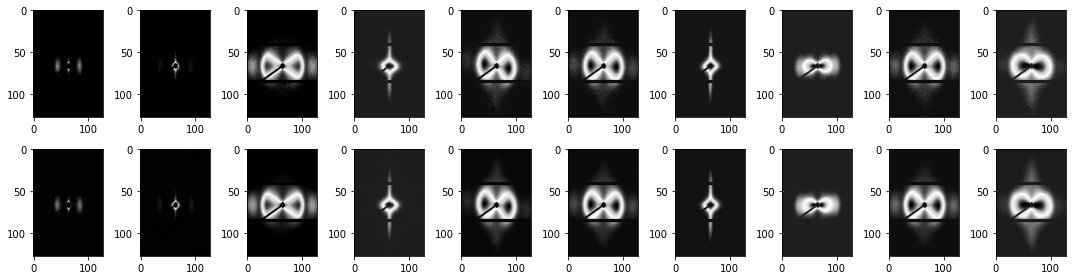

In [9]:
y_true = X_test[0:10]
y_pred = model.predict(y_true)
plot_predictions(y_true, y_pred)

In [ ]:
z_mean = enc.predict(X_train)
y1 = y_train[["tem","strain"]]
print(type(y1),y1.shape)
print(type(z_mean),z_mean.shape)
#y2 = y_train["strain"]
y1 = np.array(y1)
#y2 = np.array(y2)
#Y = np.concatenate((y1,y2),axis=0) 
print(type(y1),y1.shape)
X = z_mean
yu = 3
yd = 1
xu = 0.5
xd = 0
a = []
n = 0
for i in range(X.shape[0]):
    if xd <= X[i][0] <= xu and yd <= X[i][1] <= yu:
        cut = np.append(X[i],y1[i])
        a = np.append(a,cut)
        n = n + 1
a = a.reshape(n,4)
print(type(a),a.shape)
a

In [ ]:
m = 0
b = 0
for i in range(n):
    if a[i][2] == 50:
        b = b+a[i][3]
        m = m+1
a1 = b/m
print(a1)
m = 0
b = 0
for i in range(n):
    if a[i][2] == 60:
        b = b+a[i][3]
        m = m+1
a2 = b/m
print(a2)
m = 0
b = 0
for i in range(n):
    if a[i][2] == 70:
        b = b+a[i][3]
        m = m+1
a3 = b/m
print(a3)

In [ ]:
14/213*268

In [156]:
z_mean = enc.predict(X_train)
y1 = y_train[["tem","strain"]]
print(type(y1),y1.shape)
print(type(z_mean),z_mean.shape)
#y2 = y_train["strain"]
y1 = np.array(y1)
x = z_mean
a = np.zeros((x.shape[0],1))
print(type(a),a.shape)
x = np.append(x,a, axis=1)
print(type(x),x.shape)
X = dec.predict(z_mean)
z0 = [[0.25, -0.25]]
z0 = np.array(z0)
x0 = dec.predict(z0)
for i in range(x.shape[0]):
    mae = kr.metrics.mean_absolute_error(X[i],x0)
    if mae <= 0.03:
        x[i][2] = 1

<class 'pandas.core.frame.DataFrame'> (4793, 2)
<class 'numpy.ndarray'> (4793, 2)
<class 'numpy.ndarray'> (4793, 1)
<class 'numpy.ndarray'> (4793, 3)


In [ ]:
x = z_mean
a = np.zeros((x.shape[0],1))
print(type(a),a.shape)
x = np.append(x,a, axis=1)
print(type(x),x.shape)
X = dec.predict(z_mean)
z0 = [[-1, 2]]
z0 = np.array(z0)
x0 = dec.predict(z0)
for i in range(x.shape[0]):
    mae = kr.metrics.mean_absolute_error(X[i],x0)
    if mae <= 0.02:
        x[i][2] = 1
z0 = [[1, 2]]
z0 = np.array(z0)
x0 = dec.predict(z0)
for i in range(x.shape[0]):
    mae = kr.metrics.mean_absolute_error(X[i],x0)
    if mae <= 0.02:
        x[i][2] = 2
z0 = [[-0.5, 0]]
z0 = np.array(z0)
x0 = dec.predict(z0)
for i in range(x.shape[0]):
    mae = kr.metrics.mean_absolute_error(X[i],x0)
    if mae <= 0.02:
        x[i][2] = 3
z0 = [[1, -1]]
z0 = np.array(z0)
x0 = dec.predict(z0)
for i in range(x.shape[0]):
    mae = kr.metrics.mean_absolute_error(X[i],x0)
    if mae <= 0.02:
        x[i][2] = 4        

In [157]:
n1 = 0
n2 = 0
n3 = 0
n4 = 0
n0 = 0
for i in range(x.shape[0]):
    if x[i][2] == 1:
        n1 = n1+1
#for i in range(x.shape[0]):
#    if x[i][2] == 2:
#        n2 = n2+1
#for i in range(x.shape[0]):
#    if x[i][2] == 3:
#        n3 = n3+1
#for i in range(x.shape[0]):
#    if x[i][2] == 4:
#        n4 = n4+1
for i in range(x.shape[0]):
    if x[i][2] == 0:
        n0 = n0+1
n = n1+n2+n3+n4+n0
print(n1)
print(n2)
print(n3)
print(n4)
print(n0)
print(n)

534
0
0
0
4259
4793


In [158]:
x_train, x_test, y_train1, y_test1 = train_test_split(y1, x[:,2], test_size=0.05)
print(type(x_train),x_train.shape)
print(type(y_train),y_train.shape)

<class 'numpy.ndarray'> (4553, 2)
<class 'pandas.core.frame.DataFrame'> (4793, 2)


In [ ]:
dnn = kr.Sequential([
    kr.layers.Dense(64, activation='relu', input_shape=(2,)),
    kr.layers.Dense(32, activation='relu'),
#    kr.layers.Dense(32, activation='relu'),
    kr.layers.Dense(2, activation='sigmoid')
])
dnn.summary()
dnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = dnn.fit(x_train, y_train1, batch_size=100, epochs=500)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
#plt.savefig(r"C:\Users\zch\Desktop\6.1\数据整理\dnn2")

In [161]:
test_loss, test_acc = dnn.evaluate(x_test, y_test1, verbose=2)

print('\nTest accuracy:', test_acc)

8/8 - 0s - loss: 0.0063 - accuracy: 0.9958

Test accuracy: 0.9958333373069763


In [149]:
predictions = dnn.predict(x_test)

In [ ]:
for i in range(240):
    print(predictions[i])
    print(np.argmax(predictions[i]))
    print(y_test[i])

<class 'numpy.ndarray'> (250000,)
<class 'numpy.ndarray'> (250000,)
<class 'numpy.ndarray'> (2, 250000)
<class 'numpy.ndarray'> (250000, 2)
<class 'numpy.ndarray'> (250000,)
<class 'numpy.ndarray'> (500, 500)


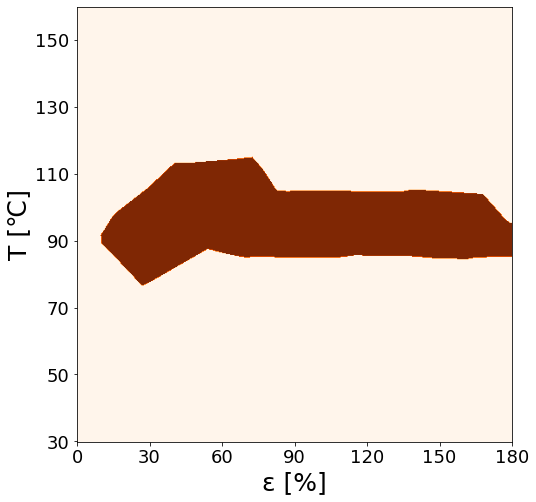

In [167]:
n = 500
tem = n
string = n
#zzz = zz[[20]]
#zzz = zzz.repeat(100, axis=0)
#print(type(zzz),zzz.shape)
t = np.linspace(30, 160, tem)
s = np.linspace(0,180, string)
gxx = np.repeat(t, n)
gyy = np.tile(s, n)
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
#gxx = gxx.transpose()
#gyy = gyy.transpose()
#print(type(gxx),gxx.shape)
#print(type(gyy),gyy.shape)
gzz = np.stack((gxx,gyy))
print(type(gzz),gzz.shape)
gzz = gzz.transpose()
print(type(gzz),gzz.shape)
X = dnn.predict(gzz)
X1 = []
for i in range(n*n):
    X1.append(np.argmax(X[i]))
X1 = np.array(X1)
print(type(X1),X1.shape)
X1 = X1.reshape(n,n)
print(type(X1),X1.shape)
plt.figure(figsize=(8, 8))
plt.imshow(X1, cmap = 'Oranges', origin = 'lower')
plt.xticks(np.arange(0,500,83.33),np.arange(0,181,30))
plt.yticks(np.arange(0,500,76.92),np.arange(30,160,20))
#plt.yticks(np.arange(0,500,50),np.arange(30,161,15))
#cb1 = plt.colorbar(fraction = 0.02, pad = 0.05)
#cb1.set_ticks([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("ε [%]",fontsize = 25)
plt.ylabel("T [℃]",fontsize = 25)
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\map02")

In [ ]:
gzz = gzz.reshape(100,100,2)
gzz

In [9]:
z_mean = enc.predict(X_train)
y1 = y_train[["tem","strain"]]
print(type(y1),y1.shape)
print(type(z_mean),z_mean.shape)
#y2 = y_train["strain"]
y1 = np.array(y1)
x = z_mean
print(type(x),x.shape)

<class 'pandas.core.frame.DataFrame'> (4793, 2)
<class 'numpy.ndarray'> (4793, 2)
<class 'numpy.ndarray'> (4793, 2)


In [10]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(y1, x, test_size=0.05)
print(type(x_train1),x_train1.shape)
print(type(y_train1),y_train1.shape)

<class 'numpy.ndarray'> (4553, 2)
<class 'numpy.ndarray'> (4553, 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 21.0784 - mae: 2.9387 - mse: 21.0784 - val_loss: 1.0906 - val_mae: 0.8358 - val_mse: 1.0906
Epoch 2/1000
41/41 [==============================] - 0s 730us/step - loss: 0.9408 - mae: 0.7854 - mse: 0.9408 - val_loss: 0.7113 - val_mae: 0.6943 - val_mse: 0.7113
Epoch 3/1000
41/41 [==============================] 

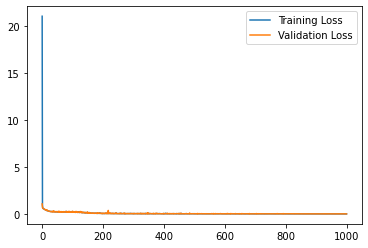

In [11]:
dnn = kr.Sequential([
    kr.layers.Dense(64, activation='relu', input_shape=(2,)),
    kr.layers.Dense(64, activation='relu'),
#    kr.layers.Dense(32, activation='relu'),
    kr.layers.Dense(2, activation='linear')
])
dnn.summary()
dnn.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])
history = dnn.fit(x_train1, y_train1, batch_size=100, epochs=1000, validation_split = 0.1, verbose=1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

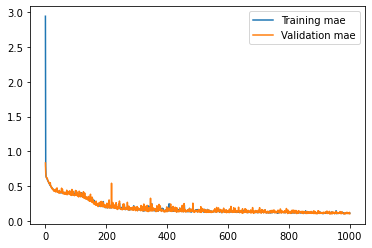

In [12]:
plt.plot(history.history['mae'], label="Training mae")
plt.plot(history.history["val_mae"], label="Validation mae")
plt.legend()

<class 'numpy.ndarray'> (240, 2)
<class 'numpy.ndarray'> (240, 2)


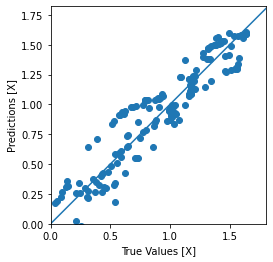

In [13]:
print(type(x_test1),x_test1.shape)
print(type(y_test1),y_test1.shape)
test_predictions = dnn.predict(x_test1)
plt.scatter(y_test1[:,0], test_predictions[:,0])
plt.xlabel('True Values [X]')
plt.ylabel('Predictions [X]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\1")

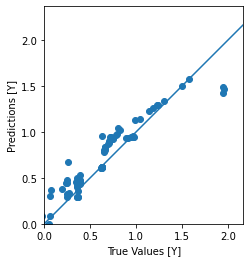

In [17]:
plt.scatter(y_test1[:,1], test_predictions[:,1])
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\2")

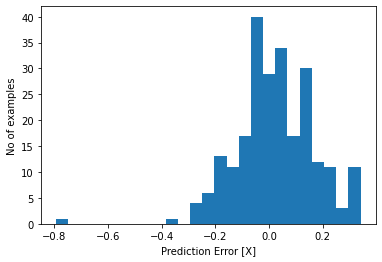

In [15]:
error = test_predictions[:,0] - y_test1[:,0]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [X]")
_ = plt.ylabel("No of examples")
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\3")

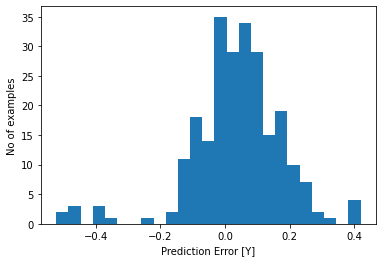

In [16]:
error = test_predictions[:,1] - y_test1[:,1]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Y]")
_ = plt.ylabel("No of examples")
plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\4")

In [54]:
print(x_test1[0])
print(y_test1[0])
print(test_predictions[0])

[160.         253.47764228]
[-0.7602957  1.5140457]
[-0.7536542  1.4721508]


<class 'numpy.ndarray'> (240, 2)


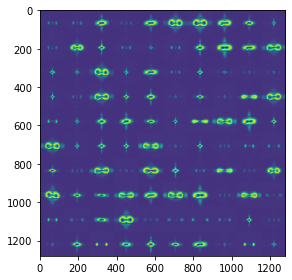

In [65]:
print(type(test_predictions),test_predictions.shape)
x = dec.predict(test_predictions[:100,:])
dst = x.reshape(10,10,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(10*128, 10*128)

# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()

<class 'numpy.ndarray'> (1, 2)


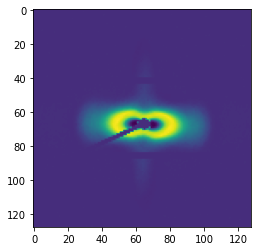

In [22]:
process = np.array([[96,50]])
print(type(process),process.shape)
letent = dnn.predict(process)
dst = dec.predict(letent)
pic = dst.reshape(128,128)
plt.imshow(pic)
#out = (cm.inferno(pic)[:,:,:3]*255).astype(np.uint8)
#skio.imsave('vae_pic_136-0.4.png', out)

<class 'numpy.ndarray'> (60, 2)
<class 'numpy.ndarray'> (60, 2)


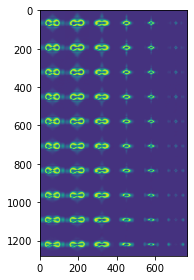

In [19]:
# decode images from 2-dim latent z
ndiv = 6 # number of images for axis
gx = np.linspace(43, 136, ndiv)
gy = np.linspace(100, 40,  10)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gxx.reshape(-1,1), gyy.reshape(-1,1), axis=1)
print(type(z),z.shape)
letent = dnn.predict(z)
print(type(letent),letent.shape)
x = dec.predict(letent)
dst = x.reshape(10,ndiv,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(10*128, ndiv*128)

# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()

In [124]:
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('vae_pic_%03d.png' % 1, out)

[180. 160. 140. 120. 100.  80.  60.  40.  20.   0.]


[ 30.          43.33333333  56.66666667  70.          83.33333333
  96.66666667 110.         123.33333333 136.66666667 150.        ]


In [19]:
from matplotlib import cm
from skimage import io as skio